In [1]:
%matplotlib inline
from __future__ import division
from data import DatFile, Data2D
import matplotlib.pyplot as plt
import itertools
from scipy import signal, ndimage, optimize
from scipy.optimize import leastsq
import numpy as np

class SimpleNamespace(object):
    """A simple container for parameters."""
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [2]:
def prepare_data(filename, v_min, v_max, chop=True):
    data = np.load(filename).item()
    
    # The abs z array may contain a (now useless) mask, which we discard
    if isinstance(data['z'], np.ma.core.MaskedArray):
        data['z'] = data['z'].data
    data['x'] *= 1e6 * 0.4835 # Convert voltage axis to µV and then to GHz
    
    # Chop data to include only desired region
    if chop:
        for key, val in data.iteritems():
            a = val[:,v_min:v_max] # the indeces at which we chop are chosen by eye
            data[key] = a
    
    # We only need one array for field and voltage values
    y = data['y'][:,0] 
    x = data['x'][0] ## NOTE: THIS MUST BE CORRECTED FOR THE DRIFT!
    data['x'] = x
    data['y'] = y
    return data

# Convenience function to plot scans
def plot_datascan(d):
    z = d['z'].T[::-1]
    x = d['x']
    y = d['y']
    
    dx, dy = x[1]-x[0], y[1]-y[0]
    ranges = [y[0]-dy/2, y[-1]+dy/2, x[0]-dx/2, x[-1]+dx/2]
    
    fig, ax = plt.subplots(figsize=(5,5))
    cax = ax.imshow(z, extent = ranges, aspect='auto', interpolation='none', cmap='gist_heat_r')
    cbar = fig.colorbar(cax)
    ax.autoscale(False)

In [3]:
data_abs = prepare_data("rawdata_dderiv.npy", 35, 70)
data_lc = prepare_data("rawdata.npy", 6, 60)

## Calibration of phase axis

This procedure assumes a linear relation $\Phi/\Phi_0 = a B + b$.

In [4]:
def calibration_phase_axis(data1, data2, i1=2, e1=12, i2=20, e2=35):
    z1 = data1['z']
    z2 = data2['z']
    left1 = z1[i1:e1]
    left2 = z2[i2:e2]
    # find most symmetric slice on right part of the dataset
    idx1 = np.argmin([np.linalg.norm(left1-np.flipud(z1[n:n+(e1-i1)])) for n in xrange(len(z1)-(e1-i1))])
    idx2 = np.argmin([np.linalg.norm(left2-np.flipud(z2[n:n+(e2-i2)])) for n in xrange(len(z2)-(e2-i2))])
    # Find Bpi
    x1, x2 = data1['y'][e1-1], data1['y'][idx1]
    Bpi = x1 + (x2 - x1) / 2
    plot_datascan(data1)
    plt.axvline(Bpi)
    plt.show()
    # Find B0
    x1, x2 = data2['y'][e2-1], data2['y'][idx2]
    B0 = x1 + (x2 - x1) / 2
    plot_datascan(data2)
    plt.axvline(B0)
    plt.show()
    a, b =  - 2 * (Bpi - B0), B0
    for data in [data1, data2]:
        data['y'] -= b
        data['y'] /= a
        data['y'] *= 2*np.pi
    return a, b

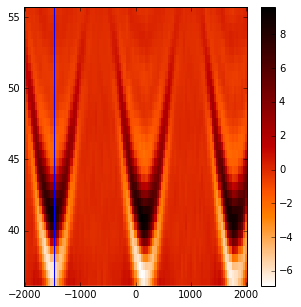

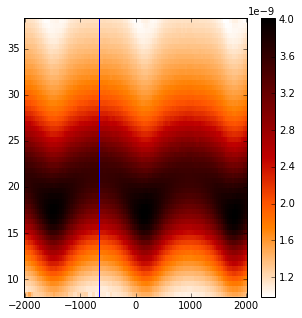

(1640.0, -660.0)

In [5]:
calibration_phase_axis(data_abs, data_lc, 2, 12, 20, 35)

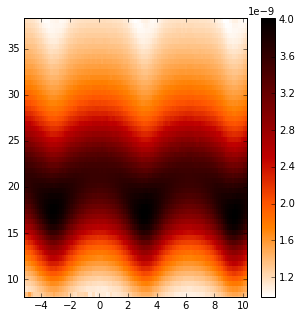

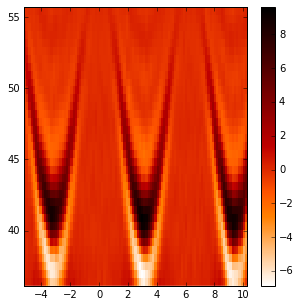

In [6]:
plot_datascan(data_lc)
plot_datascan(data_abs)

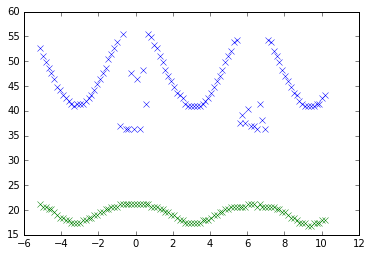

In [7]:
# Peak position are simply chosen as the maxima of each data cut for a fixed phase.
lc_pos = np.array([data_lc['x'][np.argmax(d)] for d in data_lc['z']])
abs_pos = np.array([data_abs['x'][np.argmax(d)] for d in data_abs['z']])
# This leaves some spurious points close to flux = 0 and flux = 1 for the ABS line
plt.plot(data_abs['y'], abs_pos, 'x')
plt.plot(data_lc['y'], lc_pos, 'x')

In [8]:
# These spurious points are removed manually; then we zip phi and V coordinates together
lc_line = zip(data_lc['y'], lc_pos)
abs_line = zip(np.concatenate((data_abs['y'][:28], data_abs['y'][38:69], data_abs['y'][80:])),
               np.concatenate((abs_pos[:28], abs_pos[38:69], abs_pos[80:])))

In [9]:
# A problem with the points is that, due to finite resolution,
# some consecutive points have equal values of voltage. We merge these points
# by taking their average x.
lines = []
for k, group in itertools.groupby(lc_line + abs_line, lambda l: l[1]):
    xs = [g[0] for g in group]
    lines.append((np.mean(xs), k))

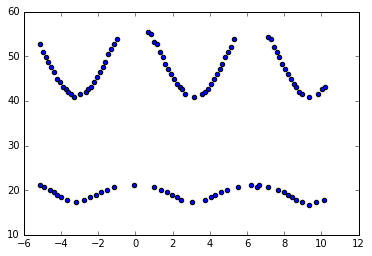

In [10]:
# This is the final dataset
# No error bars (yet..)
phase, frequency = zip(*lines)
plt.scatter(phase, frequency)

## Theoretical model

In [38]:
def potential(phi, p, s='0'):
    r = np.sqrt(1 - p.T) # use reflection amplitude in the formulas, for brevity
    if s == 'z':
        phi = p.flux - phi
        return np.cos(0.5 * r * phi) * np.cos(0.5 * phi) + r * np.sin(0.5 * r * phi) * np.sin(0.5 * phi)
    elif s  == 'y':
        phi = p.flux - phi
        return r * np.cos(0.5 * r * phi) * np.sin(0.5 * phi) - np.sin(0.5 * r * phi) * np.cos(0.5 * phi)
    elif s == '0':
        return (1 - np.cos(phi))
    else:
        raise ValueError('wrong value of s')
        
def n_me(M, dk):
    x = np.pi * dk / M
    return (-1)**dk  / (np.tan(x) * np.sin(x)) / 2

def create_hamiltonian(p, M, sparse=False):
    # offset diagonal term from charging energy
    h0 = p.Ec * (M**2 - 1) / 12 * np.eye(M) + 0j
    
    # cosine part of the potential
    ks = np.arange(-(M-1)/2, (M+1)/2, 1)
    h0 += p.Ej * np.diag(np.array([potential(2 * np.pi * k / M, p, '0') for k in ks])) + 0j
     
    #off diagonal parts of the charging energy
    for dk in range(1, M):
        h0 += p.Ec * n_me(M, dk) * (np.eye(M, k=dk) + np.eye(M, k=-dk)) + 0j
    
    # z, y parts of the potential
    hz = p.Ea * np.diag(np.array([potential(2 * np.pi * k / M, p, 'z') for k in ks])) + 0j
    hy = p.Ea * np.diag(np.array([potential(2 * np.pi * k / M, p, 'y') for k in ks])) + 0j
    h = np.bmat([[h0 + hz, -1j * hy], [1j * hy, h0 - hz]])
    if sparse:
        return sp.coo_matrix(h)
    else:
        return np.array(h)

def find_optimal_M(p, max_tol = 9e-8, verbose=False):
    M = 3
    tol = 100
    H = create_hamiltonian(p, M, sparse=False)
    try:
        ens = np.linalg.eigvalsh(H)
    except np.linalg.LinAlgError:
            print "Error!!"
            print M, p.Ej, p.Ec, p.Ea, p.T, p.flux
            return H
    ens = np.linalg.eigvalsh(H)
    de = ens[1]-ens[0]
    while tol > max_tol:
        M += 4
        H = create_hamiltonian(p, M, sparse=False)
        try:
            ens = np.linalg.eigvalsh(H)
        except np.linalg.LinAlgError:
            print "Error!!"
            print M, p.Ej, p.Ec, p.Ea, p.T, p.flux
            return H
        de_new = ens[1]-ens[0]
        tol = np.abs(de_new - de)
        if verbose:
            print M, de, de_new, tol
        de = de_new
    return M

def current_operator(p, sparse=False):
    #if hasattr(p, 'M')==False:
    M = p.M if hasattr(p, 'M') else find_optimal_M(p)
    
    ks = np.arange(-(M-1)/2, (M+1)/2, 1)
    I0 = p.Ej * np.diag(np.array([potential_derivative(2 * np.pi * k / M, p, '0') for k in ks])) + 0j
    Iz = p.Ea * np.diag(np.array([potential_derivative(2 * np.pi * k / M, p, 'z') for k in ks])) + 0j
    Iy = p.Ea * np.diag(np.array([potential_derivative(2 * np.pi * k / M, p, 'y') for k in ks])) + 0j
    
    I = np.bmat([[I0 + Iz, -1j * Iy], [1j * Iy, I0 - Iz]])
    if sparse:
        return sp.coo_matrix(I)
    else:
        return np.array(I)
    
def potential_derivative(phi, p, s='0'):
    r = np.sqrt(1 - p.T) # use reflection amplitude in the formulas, for brevity
    if s == 'z':
        phi = p.flux - phi
        return - 0.5 * p.T * np.sin(0.5 * phi) * np.cos(r * 0.5 * phi)
    elif s  == 'y':
        phi = p.flux - phi
        return + 0.5 * p.T * np.sin(0.5 * phi) * np.sin(r * 0.5 * phi)
    elif s == '0':
        return np.sin(phi)
    else:
        raise ValueError('wrong value of s')

## Functions for fitting

In [45]:
def rs_abs_model(plist, xs, ys, idx, Ej=None, Ec=None, Ea=None, max_tol=9e-8, sigmas=None):
    """ Returns the list of residuals between the data points
    and the transition energies, given a list of Hamiltonian parameters.

    Parameters:
    -----------
    plist : list of floats
        List of Hamiltonian parameters (excluding flux)
    xs : 1d array
        X values of the data.
    ys : 1d array
        Y values of the data.
    sigmas: 1d array
        Y data errors, if available.
    M : int
        Size of Hamiltonian. Must be odd.
    idx : list
        Index which marks the beginning of data corresponding
        to the ABS transition line. It is used to associate each
        data point to the correct transition energy.

    Return:
    ------
    1d array of weighted residuals.
    """
    p = SimpleNamespace()
    p.flux = np.pi # Initalize value of flux to compute optimal matriz size
    
    if not Ej and not Ec and not Ea:
        p.Ec, p.Ej, p.Ea, p.T = plist
    elif not Ec and not Ea:
        p.Ec, p.Ea, p.T = plist
        p.Ej = Ej
    elif not Ea:
        p.Ea, p.T = plist
        p.Ej, p.Ec = Ej, Ec
    else:
        p.T = plist[0]
        p.Ej, p.Ec, p.Ea = Ej, Ec, Ea
    
    # if leastsq attempts T > 1, a huge residual is returned
    if int(np.floor(p.T)) is not 0:
        return 1e12 * ys
    
    print p.Ej, p.Ec, p.Ea
    print "Determining matrix size M..."
    M = find_optimal_M(p, max_tol = max_tol, verbose=True)
    print "Parameter values:"
    print p.Ec, p.Ej, p.Ea, p.T, M
    hams = []
    for x in xs:
        p.flux = x
        hams.append(create_hamiltonian(p, M, sparse=False))
    evals = [np.sort(np.linalg.eigvalsh(h)) for h in hams]
    freqs = [(ev - ev[0])[1:] for ev in evals]
    
    # Chooses which energy level is closest to the ABS line.
    # Note that it may depend on initial parameters.
    n = np.argmin(np.abs(freqs[0] - ys[idx]))
    print "Picking which is the ABS line..."
    print freqs[0][:5], ys[idx], n
    
    frequencies = np.hstack(([f[0] for f in freqs[:idx]],
                             [f[n] for f in freqs[idx:]]))
    weights = (1. / sigmas) if sigmas else 1.
    print "Sum of residues of current iteration:"
    print np.sum(np.abs(frequencies - ys))**2
    print "Going to next iteration...", "\n\n"
    return (frequencies - ys) * weights

In [13]:
def fit_abs_model(lines, idx, p0, Ej=None, Ec=None, Ea=None, max_tol=9e-7):
    """
    Returns the best estimate for the parameters p0 and their
    covariance matrix.

    The obtain the covariance matrix, the jacobian around the
    solution returned by leastsq is multiplied by the residual variance

    s = sum(rs) / (n-m)

    where n is the number of data points and m the number of fitting
    parameters. This is the same as what is done in scipy.optimize.curve_fit.
    
    Parameters:
    -----------
    lines : list
        List of points to be fitted, one list for every
        different transition.
    idx: int
        Index which marks the beginning of data corresponding
        to the ABS transition line.
    p0 : list
        Initial guess for the fitting parameters.
    Ej : float
        Josephson energy of the conventional junction.
        If Ej=None, Ej is passed via p0 and included as fitting parameter.
        Otherwise, it is kept as a fixed parameter.
    Ec : float
        Charging energy. Same instructions as Ej.
    """
    fit_result = {'initial_guess' : p0}
    xs, ys= np.asarray(zip(*lines))
    #lengths = [len(l) for l in lines]
    #idxs = [sum(lengths[:n]) for n in np.arange(1, 7)]
    (popt, pcov, infodict, errmsg, ier) = leastsq(rs_abs_model, x0=p0,
                                                  args=(xs, ys, idx, Ej, Ec, Ea, max_tol), full_output=1)
    chi_squared = (np.asarray(rs_abs_model(popt, xs, ys, idx, Ej, Ec, Ea, max_tol))**2).sum()
    chi_squared /= (len(xs) - len(popt))
    pcov = pcov * chi_squared
    std_devs = np.sqrt(np.diag(pcov))
    fit_result['popt'] = popt
    fit_result['chi_squared'] = chi_squared
    fit_result['infodict'] = infodict
    fit_result['pcov'] = pcov
    fit_result['std_devs'] = std_devs
    fit_result['errmsg'] = errmsg
    fit_result['ier'] = ier
    return fit_result

def plot_fit_results(res, lines, Ej=None, Ec=None, Ea=None):
    p =  SimpleNamespace()
    
    
    if not Ej and not Ec and not Ea:
        p.Ec, p.Ej, p.Ea, p.T = res['popt']
    elif not Ec and not Ea:
        p.Ec, p.Ea, p.T = res['popt']
        p.Ej = Ej
    elif not Ea:
        p.Ea, p.T = res['popt']
        p.Ej, p.Ec = Ej, Ec
    else:
        p.T = res['popt'][0]
        p.Ej, p.Ec, p.Ea = Ej, Ec, Ea
    
    #if not Ej and not Ec:
    #    p.Ec, p.Ej, p.Ea, p.T = res['popt']
    #elif not Ec:
    #    p.Ec, p.Ea, p.T = res['popt']
    #    p.Ej = Ej
    #else:
    #    p.Ea, p.T = res['popt']
    #    p.Ej, p.Ec = Ej, Ec
    
    p.flux = np.pi
    p.M = find_optimal_M(p, verbose=False) + 50
    
    fluxes = np.linspace(-2*np.pi, 4*np.pi, 200)
    hams = []
    for flux in fluxes:
        p.flux = flux
        hams.append(create_hamiltonian(p, p.M, sparse=False))
    evals = [np.sort(np.linalg.eigvalsh(h)) for h in hams]
    freqs = np.array([(ev - ev[0])[1:] for ev in evals])
    p.flux = 0.
    _, evec = np.linalg.eigh(create_hamiltonian(p, p.M))
    
    abs_energies = np.array([2 * p.Ea * np.sqrt(1 - p.T * np.sin(0.5 * flux)**2) for flux in fluxes])
    
    ## Plot of the fit
    fig, ax = plt.subplots(figsize=(8,8))
    for (n, f) in enumerate(freqs.T[:5]):
        print
        ax.plot(fluxes, f, c='k')
    phase, frequency = zip(*lines)
    ax.plot(fluxes, abs_energies, 'r--') # plot of 'bare' ABS energy for comparison
    ax.scatter(phase, frequency)
    ax.set_xlim((-2*np.pi, 4*np.pi))
    ax.set_title(r'$E_C=%.4s, E_J=%.4s, E_A=%.4s, T=%.4s$' % (p.Ec, p.Ej, p.Ea, p.T))
    fig.show()
    
    ## Plot of current operator matrix elements
    p.flux = np.pi
    _, evec = np.linalg.eigh(create_hamiltonian(p, p.M))
    wavefunctions = evec.T
    iop = current_operator(p)
    matrix_elements = np.array([np.abs(np.conj(wavefunctions[0]).T.dot(iop).dot(wf))**2 for wf in wavefunctions])
    matrix_elements /= matrix_elements[1] # normalize matrix elements by the 0-->1 one
    fig, ax = plt.subplots()
    ax.stem(matrix_elements[:8])
    ax.set_xlabel('n')
    ax.set_ylabel(r'$|\langle0|\,\hat{I}\,|n\rangle|^2$')
    ax.set_xlim(-0.1, 8.1)
    plt.show()
    
    ## Plot of the wavefunctions at zero flux
    p.flux = 0.
    _, evec = np.linalg.eigh(create_hamiltonian(p, p.M))
    wavefunctions = evec.T
    for (n, wf) in enumerate(wavefunctions[:6]):
        L = len(wf)
        fig, ax = plt.subplots(figsize=(5,2))
        ax.plot(np.abs(wf)**2, 'k.')
        ax.set_xlim(0, L)
        plt.axvline(L/2, c='k')
        ax.set_ylabel(r'$|\Psi(\phi)|^2$')
        ax.set_xticks([L/8, L/4, 3*L/8, 5*L/8, 3*L/4, 7*L/8])
        ax.set_xticklabels([r'$-\pi/2$', r'$0$', r'$-\pi/2$', r'$-\pi/2$', r'$0$', r'$-\pi/2$'])
        ax.set_yticks([])
        ax.set_title(r'Eigenstate n. %s' % n)
        fig.show()

## Estimating parameters for the 100 nm device

From David's estimate for $I_J^c$, I take $E_J/h \approx 39.8$ GHz.

The highest measured value for the plasma frequency is $\omega_p\approx 21.2$ GHz, slightly smaller than the one extracted from a fit of the LC resonance at pinch-off, $\omega_\textrm{pinch-off}\approx 24.4$ GHz.

I estimate charging energy as $E_C \approx \omega_p^2 / 2 E_J = 21.2^2 / (2 \cdot 39.8)$ GHz $\approx 5.65$ GHz.

For $E_A$ and transmission $T$, I take similar values as for the $30$ nm device: $E_A\approx 33$ GHz, $T\approx 0.5$.

This gives the set of initial values for the fitting.

## Fit with four free parameters

In [14]:
%%capture
p0 = [5.65, 39.8, 33, 0.9]
fitres = fit_abs_model(lines, 41, p0, max_tol=5e-6)

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


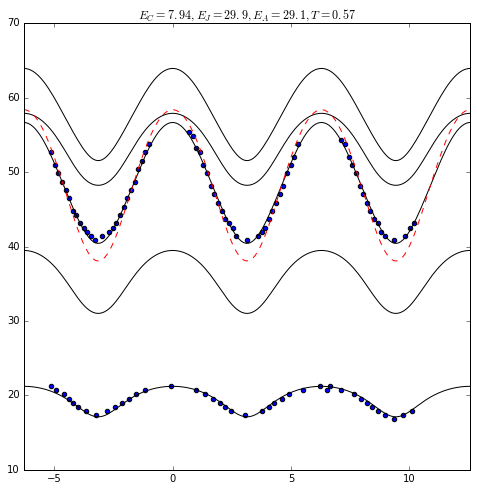

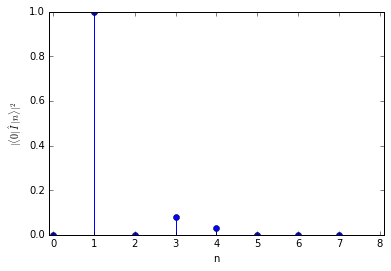

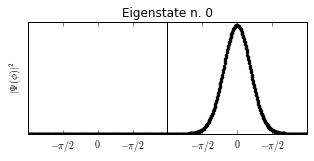

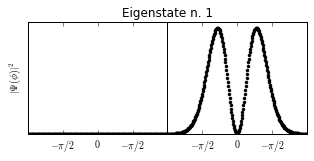

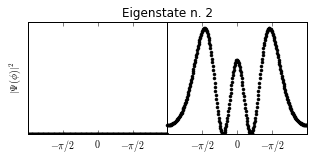

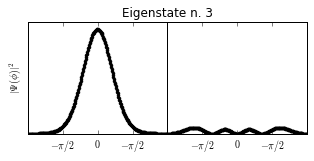

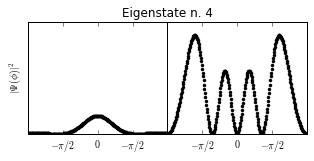

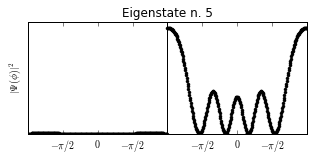

In [15]:
plot_fit_results(fitres, lines)

## Fit with three free parameters

In [16]:
%%capture
p0 = [5.65, 33, 0.9]
fitres_fixed_ej = fit_abs_model(lines, 41, p0, Ej=39.8)

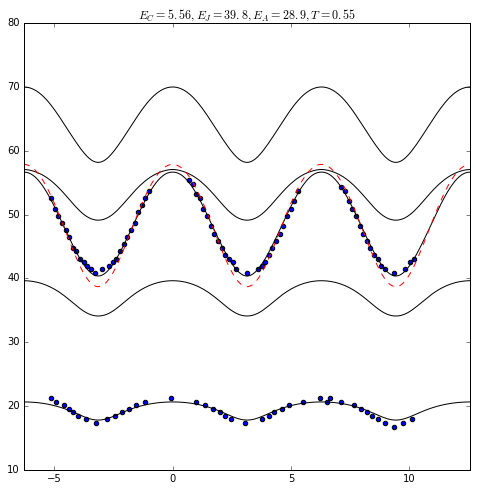

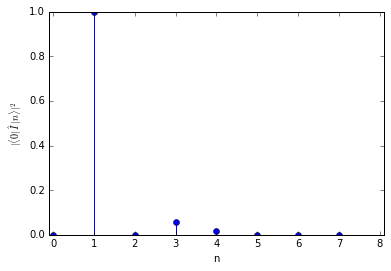

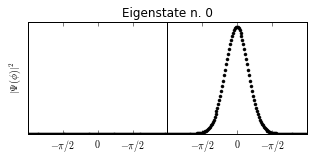

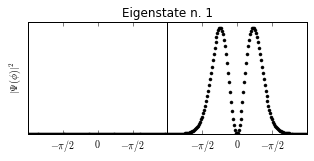

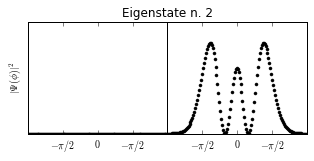

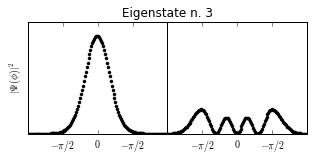

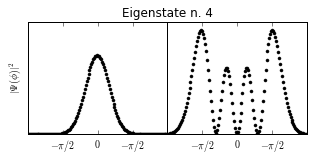

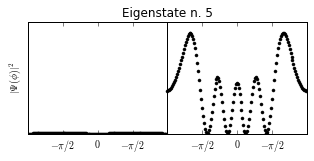

In [17]:
plot_fit_results(fitres_fixed_ej, lines, Ej=39.8)

## Fit with two free parameters

In [18]:
%%capture
p0 = [33, 0.9]
fitres_fixed_ej_and_ec = fit_abs_model(lines, 41, p0, Ej=39.8, Ec=5.65)

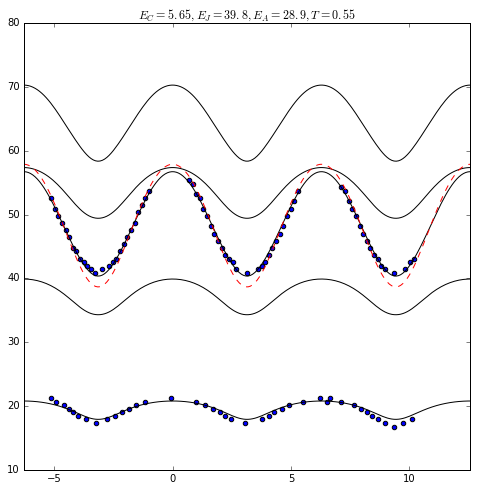

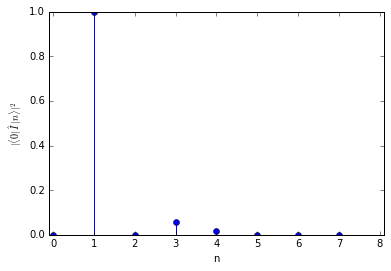

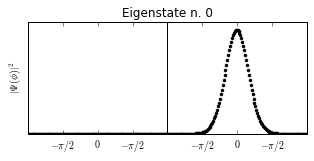

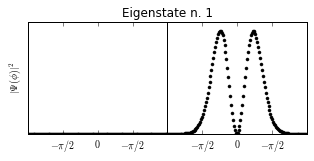

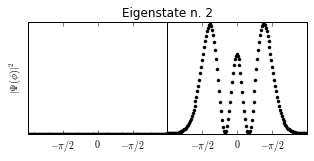

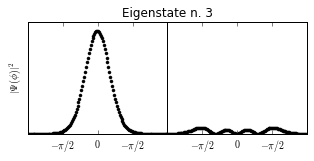

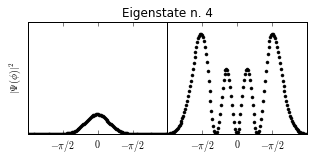

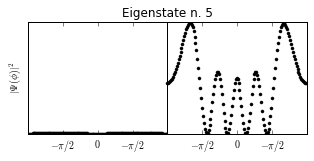

In [19]:
plot_fit_results(fitres_fixed_ej_and_ec, lines, Ej=39.8, Ec=5.65)

# Fits for scan 227

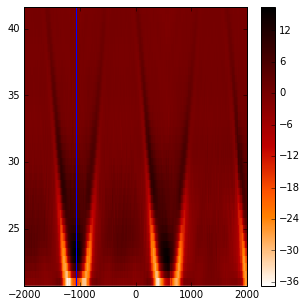

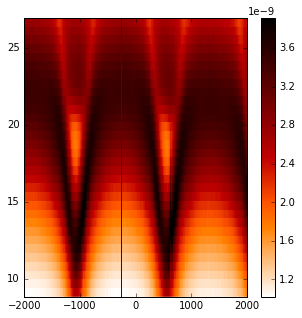

1620.0 -260.0


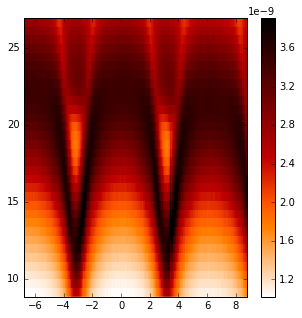

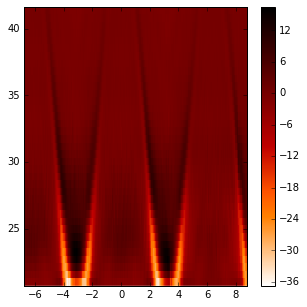

In [20]:
data_abs_227 = prepare_data("rawdata_dderiv_227.npy", 8, 45, chop=True)
data_lc_227 = prepare_data("rawdata_scan_227.npy", 8, 40)
a, b = calibration_phase_axis(data_abs_227, data_lc_227, i1=30, e1=42, i2=100, e2=125)
print a, b
plot_datascan(data_lc_227)
plot_datascan(data_abs_227)

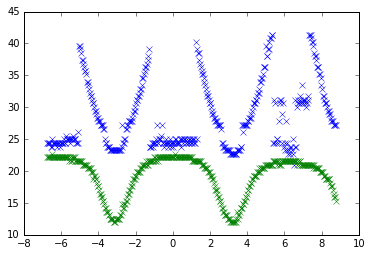

In [21]:
# Peak position are simply chosen as the maxima of each data cut for a fixed phase.
lc_227 = np.array([data_lc_227['x'][np.argmax(d)] for d in data_lc_227['z']])
abs_227 = np.array([data_abs_227['x'][np.argmax(d)] for d in data_abs_227['z']])
# This leaves some spurious points close to flux = 0 and flux = 1 for the ABS line
plt.plot(data_abs_227['y'], abs_227, 'x')
plt.plot(data_lc_227['y'], lc_227, 'x')

In [22]:
# These spurious points are removed manually; then we zip phi and V coordinates together
lc_line_227 = zip(data_lc_227['y'], lc_227)
abs_line_227 = zip(np.concatenate((data_abs_227['y'][44:142], data_abs_227['y'][209:303], data_abs_227['y'][363:])),
               np.concatenate((abs_227[44:142], abs_227[209:303], abs_227[363:])))

In [23]:
# A problem with the points is that, due to finite resolution,
# some consecutive points have equal values of voltage. We merge these points
# by taking their average x.
lines_227 = []
for k, group in itertools.groupby(lc_line_227 + abs_line_227, lambda l: l[1]):
    xs = [g[0] for g in group]
    lines_227.append((np.mean(xs), k))

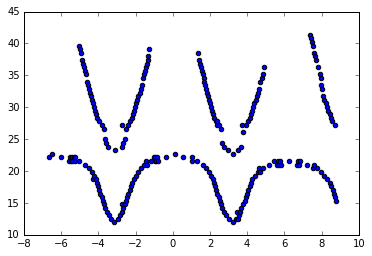

In [24]:
# This is the final dataset
# No error bars (yet..)
phase, frequency = zip(*lines_227)
plt.scatter(phase, frequency)

## Fit with three free parameters

In [25]:
%%capture
p0 = [5.65, 33, 0.9]
fitres_fixed_ej_227 = fit_abs_model(lines_227, 123, p0, Ej=39.8)

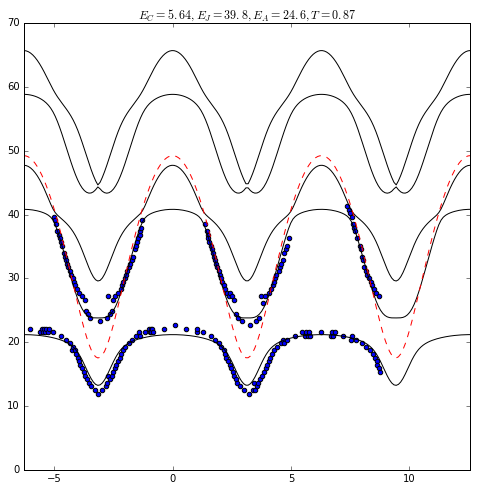

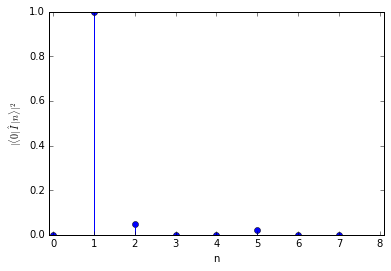

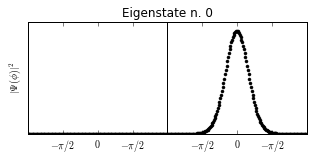

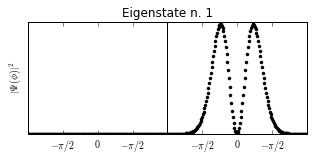

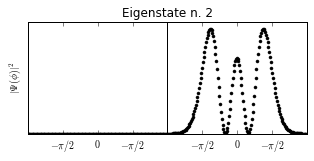

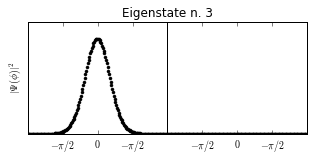

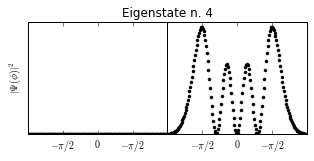

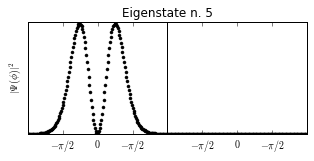

In [26]:
plot_fit_results(fitres_fixed_ej_227, lines_227, Ej=39.8)

## Fit with only one free parameter, T

In [27]:
%%capture
p0 = [0.78]
fitres_all_fixes_227 = fit_abs_model(lines_227, 123, p0, Ej=39.8, Ec=5.65, Ea=28.95)

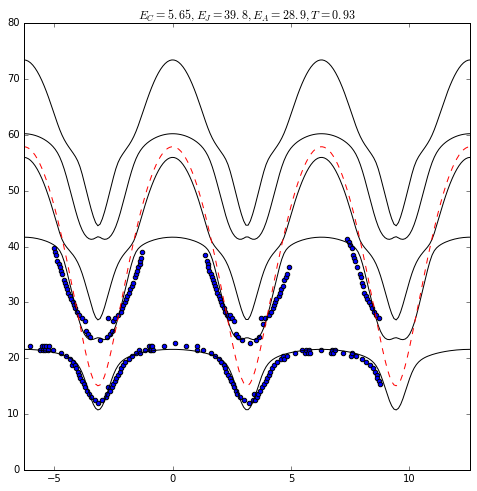

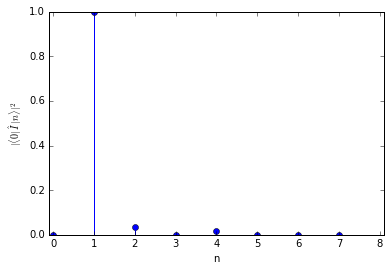

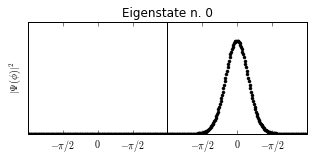

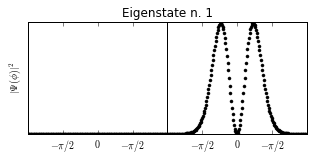

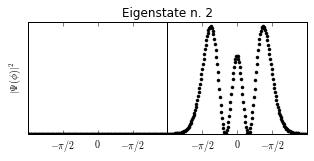

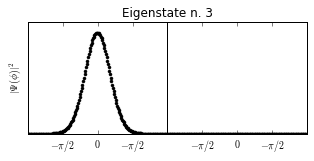

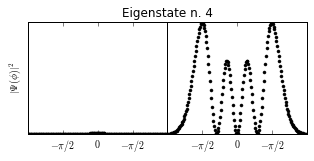

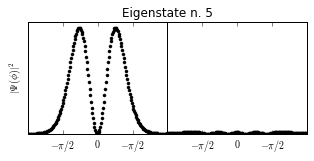

In [28]:
plot_fit_results(fitres_all_fixes_227, lines_227, Ej=39.8, Ec=5.65, Ea=28.95)

## Fit with two free parameters

In [29]:
%%capture
p0 = [25, 0.9]
fitres_no_Ej_and_Ec_227 = fit_abs_model(lines_227, 123, p0, Ej=39.8, Ec=5.65, max_tol=9e-6)

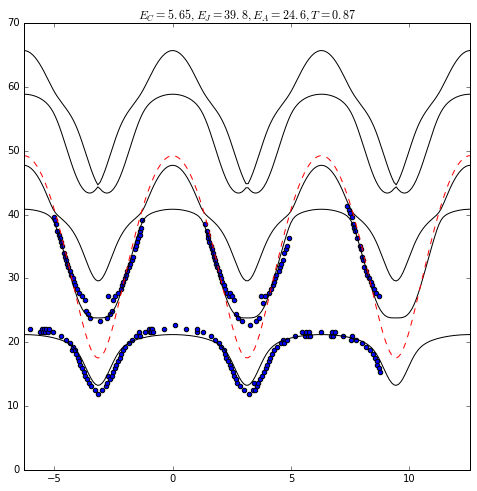

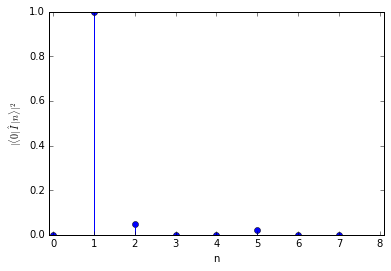

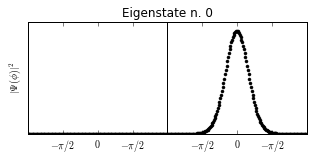

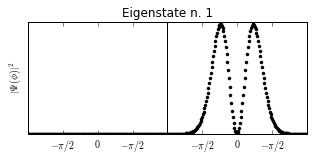

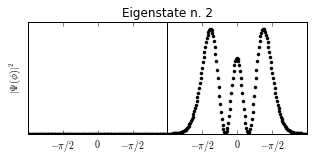

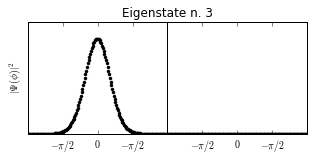

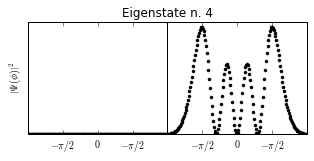

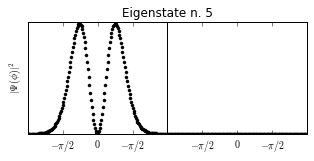

In [30]:
plot_fit_results(fitres_no_Ej_and_Ec_227, lines_227, Ej=39.8, Ec=5.65)